In [1]:
!pip install -q xgboost pandas-profiling
!pip install --upgrade joblib==1.3.2
!pip install -U xgboost
!pip install -U scikit-learn

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.6/262.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.8/309.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 10.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", b

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
#import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

In [3]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['target'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval = None)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Encoding

In [5]:
trainx = pd.read_csv(r"train_x.csv")
trainy = pd.read_csv(r"train_y.csv")

trainx['Loan type dup1'] = trainx['Loan type']
trainx.rename(columns = {'Loan type':'Loan_type_A'}, inplace = True)
trainx.rename(columns = {'Loan type dup1':'Loan_type_B'}, inplace = True)
trainx['Occupation type dup1'] = trainx['Occupation type']
trainx['Occupation type dup2'] = trainx['Occupation type']
trainx.rename(columns = {'Occupation type':'Occupation_type_X'}, inplace = True)
trainx.rename(columns = {'Occupation type dup1':'Occupation_type_Y'}, inplace = True)
trainx.rename(columns = {'Occupation type dup2':'Occupation_type_Z'}, inplace = True)
trainx.Loan_type_A[trainx.Loan_type_A == "A"] = 1
trainx.Loan_type_A[trainx.Loan_type_A == "B"] = 0
trainx.Loan_type_B[trainx.Loan_type_B == "B"] = 1
trainx.Loan_type_B[trainx.Loan_type_B == "A"] = 0
trainx.Occupation_type_X[trainx.Occupation_type_X == "X"] = 1
trainx.Occupation_type_X[trainx.Occupation_type_X == "Y"] = 0
trainx.Occupation_type_X[trainx.Occupation_type_X == "Z"] = 0
trainx.Occupation_type_Y[trainx.Occupation_type_Y == "X"] = 0
trainx.Occupation_type_Y[trainx.Occupation_type_Y == "Y"] = 1
trainx.Occupation_type_Y[trainx.Occupation_type_Y == "Z"] = 0
trainx.Occupation_type_Z[trainx.Occupation_type_Z == "X"] = 0
trainx.Occupation_type_Z[trainx.Occupation_type_Z == "Y"] = 0
trainx.Occupation_type_Z[trainx.Occupation_type_Z == "Z"] = 1
trainx = trainx[["ID","Expense","Income","Loan_type_A","Loan_type_B","Occupation_type_X","Occupation_type_Y","Occupation_type_Z","Age","Score1","Score2","Score3","Score4","Score5"]]

trainx = trainx.drop(columns = ['ID'])
categorical_columns = ["Loan_type_A","Loan_type_B","Occupation_type_X","Occupation_type_Y","Occupation_type_Z", 'Age']
numerical_columns = ['Expense','Income', 'Score1', 'Score2', 'Score3', 'Score4', 'Score5']

## Normalizing

In [6]:
scaler = MinMaxScaler()
trainx.loc(axis=1)[numerical_columns] = scaler.fit_transform(trainx.loc(axis=1)[numerical_columns])
trainx = pd.DataFrame(trainx)
X_imp = trainx.copy(deep=True)
Y_imp = trainy.drop(['ID'],axis = 1)

## Imputing


In [7]:
trainx_cont = trainx[numerical_columns]

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(random_state=0)
trainx_imp_cont = imp.fit_transform(trainx_cont)

# ✅ Convert to DataFrame with correct column names
trainx_imp_cont = pd.DataFrame(trainx_imp_cont, columns=numerical_columns)

# ✅ Add categorical/binary columns
trainx_imp_cont['Loan_type_A'] = trainx['Loan_type_A']
trainx_imp_cont['Loan_type_B'] = trainx['Loan_type_B']
trainx_imp_cont['Occupation_type_X'] = trainx['Occupation_type_X']
trainx_imp_cont['Occupation_type_Y'] = trainx['Occupation_type_Y']
trainx_imp_cont['Occupation_type_Z'] = trainx['Occupation_type_Z']
trainx_imp_cont['Age'] = trainx['Age']


In [8]:
imputer = KNNImputer(n_neighbors=1)

# First imputation on features
trainx_imp1 = imputer.fit_transform(trainx_imp_cont)
trainx_imp1 = pd.DataFrame(trainx_imp1, columns=trainx_imp_cont.columns)  # keep proper column names

# Add label
X_imp1 = trainx_imp1.copy(deep=True)
X_imp1['y'] = Y_imp['Label']

# ✅ Ensure all column names are strings
X_imp1.columns = X_imp1.columns.astype(str)

# Second imputation (now with target included)
trainxy_imp = imputer.fit_transform(X_imp1)

# ✅ Provide string column names directly here
column_names = ['Expense','Income','Loan_type_A','Loan_type_B','Occupation_type_X',
                'Occupation_type_Y','Occupation_type_Z','Age','Score1','Score2',
                'Score3','Score4','Score5','y']

trainxy_imp = pd.DataFrame(trainxy_imp, columns=column_names)

# Split features and target
y = trainxy_imp['y']
trainx_imp_final = trainxy_imp.drop(['y'], axis=1)


## Reverse Normalizing


In [9]:
inv_train = trainx_imp_final.copy(deep=True)
inv_train.loc(axis=1)[numerical_columns] = scaler.inverse_transform(trainx_imp_final.loc(axis=1)[numerical_columns])
inv_train = pd.DataFrame(inv_train)
X = inv_train.copy(deep=True)
Y = pd.DataFrame(y)
Y.rename(columns = {'y':'Label'}, inplace = True)

<Axes: >

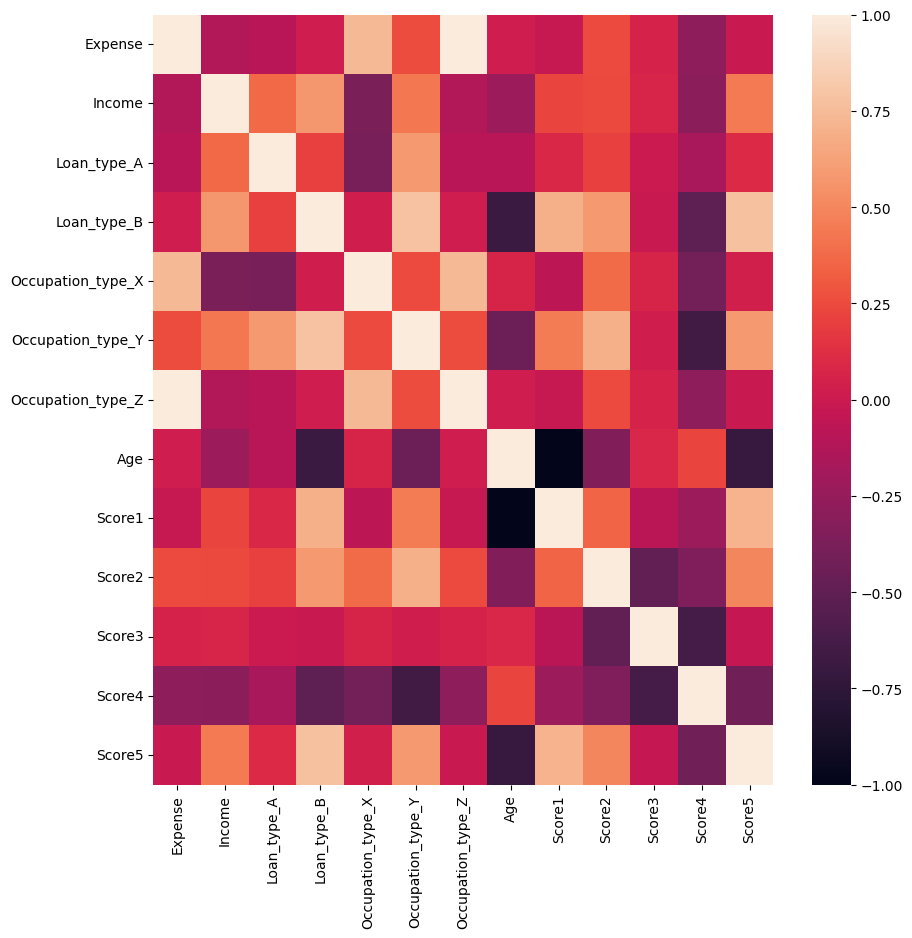

In [10]:
fig=plt.figure(figsize=(10,10))
sns.heatmap(X.corr())

As from the correlation map above it is clear that Loan_type_B, Age, Occupation_type_Z and Score5 have high correlation due to the Dummy Variable trap and have to be dropped to increase model accuracy

## Dropping Dummyvar trap

In [11]:
X = X.drop(columns = ['Loan_type_B','Occupation_type_Z'])
X = X.drop(columns = ['Score5'])
X = X.drop(columns = ['Age'])
XY = X.copy(deep=True)

XY['target'] = Y['Label']
train = XY.copy(deep=True)

## Fixing Learning rate and number of estimators

In [12]:
from xgboost import DMatrix, cv
from sklearn.metrics import accuracy_score, roc_auc_score

def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = DMatrix(dtrain[predictors].values, label=dtrain['target'].values)
        cvresult = cv(
            xgb_param,
            xgtrain,
            num_boost_round=alg.get_params()['n_estimators'],
            nfold=cv_folds,
            metrics='auc',
            early_stopping_rounds=early_stopping_rounds,
            seed=27
        )
        alg.set_params(n_estimators=cvresult.shape[0])

    # Fit model WITHOUT using eval_metric keyword
    alg.fit(dtrain[predictors], dtrain['target'])

    # Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]

    # Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain['target'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain['target'], dtrain_predprob))


In [13]:
predictors = [x for x in XY.columns if x not in ['target']]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder = False)
modelfit(xgb1, XY, predictors)


Model Report
Accuracy : 0.9886
AUC Score (Train): 0.995143


## Tuning Max_depth and Min_child_weight

In [14]:
# First, explicitly install/upgrade scikit-learn
#!pip install -U scikit-learn

# Then, re-run the cell that defines and fits gsearch1
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the full grid without setting any conflicting params in constructor
param_grid = {
    'max_depth': range(6, 20, 2),
    'min_child_weight': range(1, 6, 2),
    'learning_rate': [0.1],
    'n_estimators': [140],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'scale_pos_weight': [1]
}

# Minimal clean base model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    # Changed n_jobs from -1 to 1 to avoid multiprocessing issues
    n_jobs=1,
    random_state=27
)

# Grid search setup
gsearch1 = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    # Changed n_jobs from -1 to 1 here as well
    n_jobs=1,
    cv=5,
    verbose=1,
    error_score='raise'
)

# Fit the model (XY and predictors must be defined properly)
# Ensure XY and predictors are defined in a previous cell if this is a standalone cell
gsearch1.fit(XY[predictors], XY['target'])

# Output best params and score
print("✅ Best Parameters:", gsearch1.best_params_)
print("📈 Best ROC-AUC Score:", gsearch1.best_score_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
✅ Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 140, 'scale_pos_weight': 1, 'subsample': 0.8}
📈 Best ROC-AUC Score: 0.98027774611287


## Tune Gamma

In [16]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,learning_rate =0.1, n_estimators=140, max_depth=12,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(XY[predictors],XY['target'])
# gsearch3.cv_results_,
gsearch3.best_params_, gsearch3.best_score_

({'gamma': 0.2}, np.float64(0.9802835508155576))

## Recalibrating the classifier

In [17]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=12,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 use_label_encoder = False)
modelfit(xgb2, XY, predictors)


Model Report
Accuracy : 0.9948
AUC Score (Train): 0.999649


## Tuning subsample and colsample_bytree

In [19]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,learning_rate =0.1, n_estimators=177, max_depth=12,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(train[predictors],train['target'])
# gsearch4.cv_results_,
gsearch4.best_params_, gsearch4.best_score_


({'colsample_bytree': 0.9, 'subsample': 0.9}, np.float64(0.980751478592072))

# Tuning reg_alpha

In [20]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,learning_rate =0.1, n_estimators=177, max_depth=12,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27),
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(train[predictors],train['target'])
# gsearch6.cv_results_,
gsearch6.best_params_, gsearch6.best_score_

({'reg_alpha': 1e-05}, np.float64(0.9802598355499723))

# Tuning reg_lambda

In [21]:
param_test8 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(use_label_encoder = False,learning_rate =0.1, n_estimators=177, max_depth=12,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27,reg_alpha = 0.1),
 param_grid = param_test8, scoring='roc_auc',n_jobs=4, cv=5)
gsearch8.fit(train[predictors],train['target'])
gsearch8.best_params_, gsearch8.best_score_

({'reg_lambda': 0.01}, np.float64(0.9801416220159643))

# Final Model

In [22]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=12,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha = 0.1,
 reg_lambda = 1,
 seed=27,
 use_label_encoder = False)
modelfit(xgb4, XY, predictors)



Model Report
Accuracy : 0.9917
AUC Score (Train): 0.998502


# Train-Test split

In [23]:
X_train,x ,Y_train, y = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y)

model1 = xgb4.fit(X_train,Y_train)
y_pred_xgb4_train = model1.predict(X_train)
y_pred_xgb4_test = model1.predict(x)
f2score_test = fbeta_score(y,y_pred_xgb4_test,average ='binary',beta=2)
f2score_train = fbeta_score(Y_train,y_pred_xgb4_train,average='binary',beta=2)
acc_test = accuracy_score(y,y_pred_xgb4_test)
acc_train = accuracy_score(Y_train,y_pred_xgb4_train)

print("Training Data Set Accuracy for xgb: ", accuracy_score(Y_train,y_pred_xgb4_train))
print("Training Data F2 Score for xgb: ", f2score_train)
print("Validation Mean F2 Score for xgb: ",f2score_test)
print("Validation Mean Accuracy for xgb: ",accuracy_score(y,y_pred_xgb4_test))


Training Data Set Accuracy for xgb:  0.99203125
Training Data F2 Score for xgb:  0.9135312892929683
Validation Mean F2 Score for xgb:  0.8432675395739692
Validation Mean Accuracy for xgb:  0.985125


# KFold Cross Validation Score

In [25]:
kfold = KFold(n_splits=10, shuffle=True, random_state=7)
scoresxgb = cross_val_score(model1, X, Y, cv=kfold)
accuracy_xgb= scoresxgb.mean() * (-1)
accuracy_xgb

np.float64(-0.98485)

# Importing Test Data and Preprocessing

In [27]:
testx = pd.read_csv(r"test_x.csv")

In [28]:
testx['Loan type dup1'] = testx['Loan type']
testx.rename(columns = {'Loan type':'Loan_type_A'}, inplace = True)
testx.rename(columns = {'Loan type dup1':'Loan_type_B'}, inplace = True)
testx['Occupation type dup1'] = testx['Occupation type']
testx['Occupation type dup2'] = testx['Occupation type']
testx.rename(columns = {'Occupation type':'Occupation_type_X'}, inplace = True)
testx.rename(columns = {'Occupation type dup1':'Occupation_type_Y'}, inplace = True)
testx.rename(columns = {'Occupation type dup2':'Occupation_type_Z'}, inplace = True)
testx.Loan_type_A[testx.Loan_type_A == "A"] = 1
testx.Loan_type_A[testx.Loan_type_A == "B"] = 0
testx.Loan_type_B[testx.Loan_type_B == "B"] = 1
testx.Loan_type_B[testx.Loan_type_B == "A"] = 0
testx.Occupation_type_X[testx.Occupation_type_X == "X"] = 1
testx.Occupation_type_X[testx.Occupation_type_X == "Y"] = 0
testx.Occupation_type_X[testx.Occupation_type_X == "Z"] = 0
testx.Occupation_type_Y[testx.Occupation_type_Y == "X"] = 0
testx.Occupation_type_Y[testx.Occupation_type_Y == "Y"] = 1
testx.Occupation_type_Y[testx.Occupation_type_Y == "Z"] = 0
testx.Occupation_type_Z[testx.Occupation_type_Z == "X"] = 0
testx.Occupation_type_Z[testx.Occupation_type_Z == "Y"] = 0
testx.Occupation_type_Z[testx.Occupation_type_Z == "Z"] = 1
testx = testx[["ID_Test","Expense","Income","Loan_type_A","Loan_type_B","Occupation_type_X","Occupation_type_Y","Occupation_type_Z","Age","Score1","Score2","Score3","Score4","Score5"]]

testx = testx.drop(columns = ['ID_Test'])
testx = testx.drop(columns = ['Loan_type_B','Occupation_type_Z'])
testx = testx.drop(columns = ['Age','Score5'])
testx['Loan_type_A'] = pd.to_numeric(testx['Loan_type_A'])
testx['Occupation_type_X'] = pd.to_numeric(testx['Occupation_type_X'])
testx['Occupation_type_Y'] = pd.to_numeric(testx['Occupation_type_Y'])

# Predicting the values

In [31]:
# Fit the model and predict
model   = xgb4.fit(X, Y)
y_pred  = model.predict(testx)

# Build submission dataframe correctly
y_pred_f = pd.DataFrame(y_pred, columns=['Label'])      # <-- list, not set
y_pred_f['ID'] = range(1, len(testx) + 1)

# Re-order columns (ID first, then Label)
y_pred_f = y_pred_f[['ID', 'Label']]

# Save to CSV
y_pred_f.to_csv(r'pred_y.csv', index=False)
